# RealNVP

Real-Valued Non-Volume Preserving Transformation- is the flow-based class of Neural models, which is a tytpe of a probabilistic generative models that uses a sequence of invertible transformations to model complex data distributions

Some key characteristics are:
- Use bijective(invertible) functions, allowing efficien computation of forward of data to latent space and reverse transformation to data space. This means no information will be lost during the recovering from the latent space
- Use of Jacobian Determinant which is essential for handle dimensionality changes without losing data.

Applied areas:
- Density Estimation and Anomaly Detection. The exact likelihood computation makes it easier to identify anomalies
- Image and Vide generation
- Reversible data compression
- Data augmentation for cases when there are lack of original data
- Bayesian Inference and Probabillists modeling when uncertanty

## INITIALIZATION

### Imports

In [2]:
from sklearn import datasets
from tensorflow.keras import (
    layers,
    regularizers,
    models,
    metrics,
    optimizers,
    callbacks
)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow_probability as tfp
import numpy as np
import tensorflow as tf
import datetime

2024-11-06 22:27:34.322603: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 22:27:34.348390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 22:27:34.348425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 22:27:34.349521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 22:27:34.354010: I tensorflow/core/platform/cpu_feature_gua

### Functions

In [3]:
def display_img(images, n=10, fig_size=(20, 3), c_map='gray_r', as_type='float32', save_to=None):
    if save_to is not None:
        oFull_path = Path(save_to)
        
        oFull_path.parent.mkdir(parents=True, exist_ok=True)

    
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=fig_size)

    for i in range(n):
        plt.imshow(images[i].astype(as_type), cmap=c_map)
        plt.axis('off')

    # Сохранение изображения
    if save_to:
        plt.savefig(save_to)

    plt.show()

### Dataset generation

By using a scikit library generate a toy dataset with datapoints that forms two interleaving half circles

In [4]:
x, y = datasets.make_moons(30000, noise=5e-2)
x = x.astype('float32')
df = pd.DataFrame(x, columns=['x1', 'x2'])
df['label'] = y

## EDA

### Original

In [5]:
df.shape

(30000, 3)

In [6]:
df.head()

,x1,x2,label
0,0.423702,0.933059,0
1,-0.455023,0.852446,0
2,0.960438,0.093677,0
3,-0.030935,1.035122,0
4,0.539153,0.685117,0


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x1,30000.0,0.499949,0.867379,-1.179715,-0.042626,0.501169,1.042474,2.158802
x2,30000.0,0.250016,0.496771,-0.660604,-0.203572,0.249578,0.706322,1.159757
label,30000.0,0.500000,0.500008,0.000000,0.000000,0.500000,1.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      30000 non-null  float32
 1   x2      30000 non-null  float32
 2   label   30000 non-null  int64  
dtypes: float32(2), int64(1)
memory usage: 468.9 KB


In [9]:
df['label'].value_counts(normalize=True)

label
0    0.5
1    0.5
Name: proportion, dtype: float64

**INTERIM CONCLUSION**

We observe our dataset has been generated without missing data and in accordance with given parametrs. We see that our data is equally balanced and symetricly distributed.  

In a reson of that we see uneven distribution and scale factor between x1 and x2, as well as different centers it is recomended to normalize data

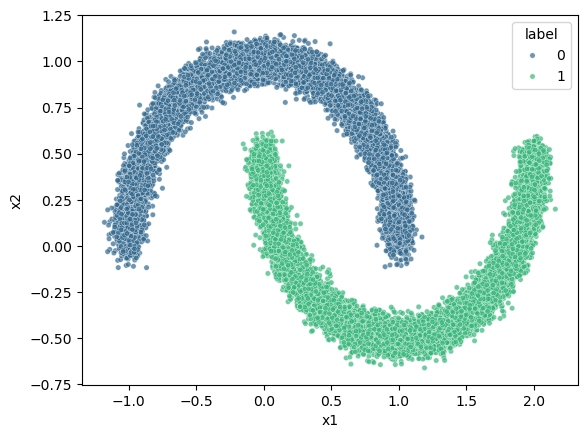

In [10]:
sns.scatterplot(
    data=df, 
    x='x1',
    y='x2',
    hue='label',
    palette='viridis',
    s=15,
    alpha=.7
);

**INTERIM CONCLUSION**

Visualization demonstrates how exactly generated data forms two half circles in the form of moons. Besides we alos see strong non-linear distribution

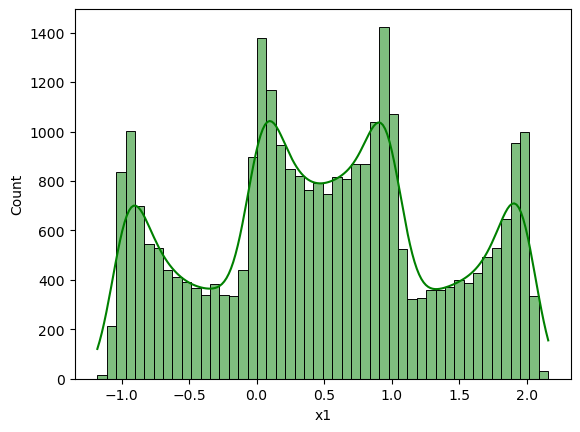

In [11]:
sns.histplot(
    df['x1'],
    kde=True,
    color='green'
);

**INTERIM CONCLUSION**

Here we observe multynidality, formed with four major peaks. 

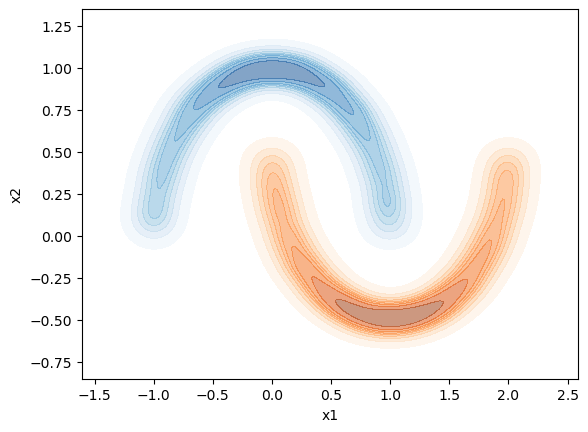

In [12]:
sns.kdeplot(
    data=df[df['label']==0],
    x='x1',
    y='x2',
    cmap='Blues',
    fill=True,
    alpha=.5,
    label='Class 0'
)
sns.kdeplot(
    data=df[df['label']==1],
    x='x1',
    y='x2',
    cmap='Oranges',
    fill=True,
    alpha=.5,
    label='Class 1'
);

**INTERIM CONCLUSION**

This viz demonstrates us a density distributions among 2 groups of data 0 and 1. We see that density distribution is even and symetrical

### Normalization

In [13]:
norm = layers.Normalization()
norm.adapt(x)
x_norm = norm(x)


2024-11-06 22:27:46.136058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-06 22:27:46.161278: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-06 22:27:46.161328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-06 22:27:46.167445: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-06 22:27:46.167493: I external/local_xla/xla/stream_executor

In [14]:
norm_df = pd.DataFrame(x_norm, columns=['x1','x2'])
norm_df['label']=y

In [15]:
print('NORMALIZED DATA')
norm_df.describe().T

NORMALIZED DATA


,count,mean,std,min,25%,50%,75%,max
x1,30000.0,-7.202149e-07,1.000018,-1.936517,-0.625546,0.001405,0.625486,1.912523
x2,30000.0,2.057393e-07,1.000019,-1.833111,-0.913088,-0.000882,0.918562,1.831343
label,30000.0,5.000000e-01,0.500008,0.000000,0.000000,0.500000,1.000000,1.000000


In [16]:
print('RAW-GENERATED DATA')
df.describe().T

RAW-GENERATED DATA


,count,mean,std,min,25%,50%,75%,max
x1,30000.0,0.499949,0.867379,-1.179715,-0.042626,0.501169,1.042474,2.158802
x2,30000.0,0.250016,0.496771,-0.660604,-0.203572,0.249578,0.706322,1.159757
label,30000.0,0.500000,0.500008,0.000000,0.000000,0.500000,1.000000,1.000000


**INTERIM CONCLUSION**

We see that after normalization being done our data distribution now more densed around 1, standard deviation is tend to 1 and  mean for both groups are now tends to zero which is desired shape, besides that we now see our data are now evenly scaled.  
Now our data is well fit for machine learning algortyrhms

## BUILD RealNVP

In [28]:
def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=(input_dim,))

    s_layer_1 = layers.Dense(
        coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(input_layer)

    s_layer_2 = layers.Dense(
        coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)

    s_layer_3 = layers.Dense(
        coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)

    s_layer_4 = layers.Dense(
        coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)

    s_layer_5 = layers.Dense(
        coupling_dim,
        activation='tanh',
        kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(input_layer)

    t_layer_2 = layers.Dense(
        coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)

    t_layer_3 = layers.Dense(
        coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)

    t_layer_4 = layers.Dense(
        coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)

    t_layer_5 = layers.Dense(
        coupling_dim,
        activation='linear',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

In [124]:
class RealNVP(models.Model):
    def __init__(self, input_dim, coupling_layers, coupling_dim, regularization):
        super(RealNVP, self).__init__()
        self.coupling_layers= coupling_layers
        self.distribution= tfp.distributions.MultivariateNormalDiag(loc=[.0,.0], scale_diag=[1.0,1.0])
        self.masks= tf.constant([[0,1],[1,0]] * (coupling_layers // 2), dtype='float32')
        self.loss_tracker= metrics.Mean(name='loss')
        self.layers_list=[Coupling(input_dim, coupling_dim, regularization) for i in range(coupling_layers)]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv= 0
        direction= 1
        
        if training:
            direction= -1

        for i in range(self.coupling_layers)[::direction]:
            x_masked= x * self.masks[i]
            reversed_mask= 1. - self.masks[i]
            
            s, t= self.layers_list[i](x_masked)
            print(f's.shape:{s.shape}, dtype:{s.dtype}')
            print(f't.shape:{t.shape}, dtype:{t.dtype}')
            print(f'reversed_mask.shape:{reversed_mask.shape}, dtype:{reversed_mask.dtype}')

            s *= reversed_mask
            t *= reversed_mask
                       
            gate= (direction -1) / 2
            x= (reversed_mask * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s)) + x_masked)
            log_det_inv += gate * tf.reduce_sum(s, axis=1)

        return x, log_det_inv

    def log_loss(self, x):
        y, logdet= self(x)
        log_likelihood= self.distribution.log_prob(y) + logdet

        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss= self.log_loss(data)

        g= tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {'loss': self.loss_tracker.result()}

    def test_step(self, data):
        loss= self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {'loss': self.loss_tracker.result()}        

In [125]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples, save_to):
        self.num_samples= num_samples
        self.save_to= save_to

    def generate(self):
        # From data to latent space(i.e. hidden)
        z, _= model(normalized_data)

        # From latent space to data
        x, _= model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes= plt.subplots(2,2)
        f.set_size(8,5)

        axes[0, 0].scatter(normalized_data[:,0], normalized_data[:,1], color='r',s=1)
        axes[0, 0].set(title='Data space X', xlabel='x_1', ylabel='x_2')
        axes[0, 0].sex_xlim([-2,2])
        axes[0, 0].set_ylim([-2,2])

        axes[0, 1].scatter(z[:,0], z[:,1], color='r', s=1)
        axes[0, 1].set(title='f(x)', xlabel='z_1', ylabel='z_2')
        axes[0, 1].set_xlim([-2,2])
        axes[0, 1].set_ylim([-2,2])

        axes[1, 0].scatter(samples[:,0], samples[:,1], color='g', s=1)
        axes[1, 0].set(title='Latent space Z', xlabel='z_1', ylabel='z_2')
        axes[1, 0].set_xlim([-2,2])
        axes[1, 0].set_ylim([-2,2])

        axes[1, 1].scatter(x[:,0], x[:1], color='g', s=1)
        axes[1, 1].set(title='g(Z)', xlabel='x_1', ylabel='x_2')
        axes[1, 1].set_xlim([-2,2])
        axex[1, 1].sey_ylim([-2,2])

        plt.subplots_adjust(wspace=.3, hspace=.6)

        if save_to:
            plt.savefig(save_to)

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            export_path=self.save_to + '/generated_one_img%03d.png' % (epoch)
            x, z, samples = self.generate()
            self.display_img(x, z, samples, save_to=export_path)
        

In [126]:
model= RealNVP(
    input_dim= 2,
    coupling_layers= 2,
    coupling_dim= 256,
    regularization=0.01
)

## TRAIN

In [127]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4))

In [128]:
log_dir='./logs/nvp/fit/moons/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

img_generator_callback=ImageGenerator(num_samples=3000,save_to=log_dir)

tensorboard_callback=callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1
)

2024-11-06 23:08:41.395530: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-06 23:08:41.395565: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-06 23:08:41.395587: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-11-06 23:08:41.395592: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-11-06 23:08:41.395594: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-11-06 23:08:41.395599: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1281] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-11-06 23:08:41.397070: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131]

In [129]:
model.fit(
    x_norm,
    batch_size=256,
    epochs=300,
    callbacks=[
        tensorboard_callback,
        img_generator_callback
    ]
)

Epoch 1/300
s.shape:(None, 256), dtype:<dtype: 'float32'>
t.shape:(None, 256), dtype:<dtype: 'float32'>
reversed_mask.shape:(None, 2), dtype:<dtype: 'float32'>


ValueError: Exception encountered when calling RealNVP.call().

[1mDimensions must be equal, but are 256 and 2 for '{{node real_nvp_17_1/mul_1}} = Mul[T=DT_FLOAT](real_nvp_17_1/functional_33_1/dense_334_1/Tanh, real_nvp_17_1/Tile)' with input shapes: [?,256], [?,2].[0m

Arguments received by RealNVP.call():
  • x=tf.Tensor(shape=(None, 2), dtype=float32)
  • training=True

In [99]:
https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.make_moons.html

SyntaxError: invalid syntax (275245.py, line 1)